## Compare filters

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from gcm_filters import filter
from gcm_filters.kernels import GridType
from gaussian_filter import gaussian_filter
import xarray as xr


Script parameters

In [120]:
filter_scale=4

Read the data from North Atlantic


In [121]:
from read_data import read_data

grid_data, data = read_data()
grid_data = grid_data.compute().reset_coords()

data = data['usurf'].isel(time=0).sel(xu_ocean=slice(-50, -30),
                                      yu_ocean=slice(20, 40)).compute()

Question: how do we address continents?

In [122]:
grid_data_save = grid_data
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]

Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [123]:
grid_data['dxt'] = grid_data['dxt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean))
grid_data['dyt'] = grid_data['dyt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean))
grid_data = grid_data.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 233)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
    time      object 0181-01-01 12:00:00
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dxu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    area_u    (yu_ocean, xu_ocean) float32 1.091e+08 1.091e+08 ... 7.258e+07
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [124]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filter = filter.Filter(16*dx_min, dx_min=dx_min, n_steps=15,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5)
print(mom5_filter.filter_spec)


FilterSpec(n_lap_steps=15, s_l=array([2.89604064e-09, 1.11296743e-08, 2.45040896e-08, 4.24580687e-08,
       6.42551848e-08, 8.90027286e-08, 1.15687420e-07, 1.43216740e-07,
       1.70463620e-07, 1.96312573e-07, 2.19705369e-07, 2.39684395e-07,
       2.55432020e-07, 2.66305270e-07, 2.71981889e-07]), n_bih_steps=0, s_b=array([], dtype=complex128))


Carry out filtering operation

In [125]:
filtered_data = mom5_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

/home/arthur/python/NYU/gcm-filters/gcm_filters/filter.py:142: RuntimeWarning: overflow encountered in multiply
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/arthur/python/NYU/gcm-filters/gcm_filters/filter.py:142: RuntimeWarning: overflow encountered in add
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:69: RuntimeWarning: invalid value encountered in float_scalars
  fx[i,j]=(field[i+1,j]-field[i,j])/(self.dxt[i+1,j])
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:73: RuntimeWarning: invalid value encountered in float_scalars
  fy[i,j]=(field[i,j+1]-field[i,j])/(self.dyt[i,j+1])
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:77: RuntimeWarning: invalid value encountered in double_scalars
  filtered_field[i,j]=((self.dyu[i,j]*fx[i,j]-self.dyu[i-1,


Plot the result

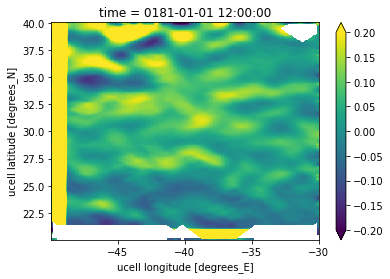

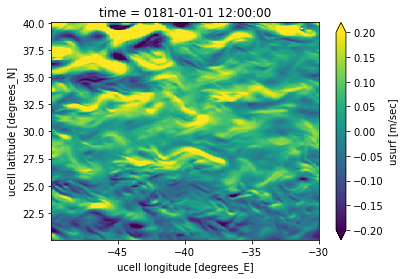

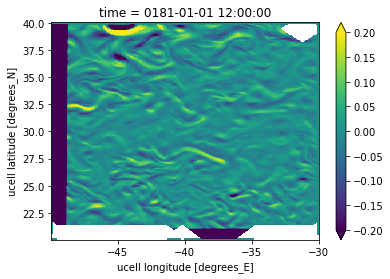

In [128]:
plt.figure()
filtered_data.plot(vmin=-0.2, vmax=0.2)
plt.figure()
data.plot(vmin=-0.2, vmax=0.2)
plt.show()
plt.figure()
(data-filtered_data).plot(vmin=-0.2, vmax=0.2)

Not much of a difference to say the least...

Now with a standard Gaussian filter

In [37]:
grid_data = grid_data_save
data2 = data.fillna(0.)
filtered_data2 = gaussian_filter(data2, grid_data, scale=4, mode='own')

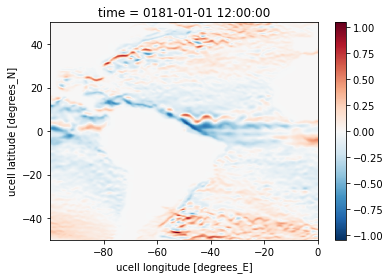

In [40]:
plt.figure()
filtered_data2.plot()